In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import random

# Dim reduction tools
import umap
from sklearn.linear_model import LinearRegression
import torch
import torch.utils.data
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.model_selection import ShuffleSplit

# 
from utils import *
import segypy 

#### Copy paste "utils.py" because it wont load/import:

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

def load_seismic(filename, inlines=[1300, 1502, 2], xlines=[1500, 2002, 2]):
    inl = np.arange(*inlines)
    crl = np.arange(*xlines)
    seis, header, trace_headers = segypy.readSegy(filename)
    amplitude = seis.reshape(header['ns'], inl.size, crl.size)
    lagtime = trace_headers['LagTimeA'][0]*-1
    twt = np.arange(lagtime, header['dt']/1e3*header['ns']+lagtime, header['dt']/1e3)
    return amplitude, twt


def load_horizon(filename, inlines=[1300, 1502, 2], xlines=[1500, 2002, 2]):
    inl = np.arange(*inlines)
    crl = np.arange(*xlines)
    hrz = np.recfromtxt(filename, names=['il','xl','z'])
    horizon = np.zeros((len(inl), len(crl)))
    for i, idx in enumerate(inl):
        for j, xdx in enumerate(crl):
            time = hrz['z'][np.where((hrz['il']== idx) & (hrz['xl'] == xdx))]
            if len(time) == 1:
                horizon[i, j] = time 

    return horizon

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

def interpolate_horizon(horizon):
    points = []
    wanted = []
    for i in range(horizon.shape[0]):
        for j in range(horizon.shape[1]):
            if horizon[i, j] != 0.:
                points.append([i, j, horizon[i, j]])
            else:
                wanted.append([i, j])
    
    points = np.array(points)
    zs2 = scipy.interpolate.griddata(points[:, 0:2], points[:, 2], wanted, method="cubic")
    for p, val in zip(wanted, zs2):
        horizon[p[0], p[1]] = val
    
    return horizon

def plot_section_horizon_and_well(ax, amplitude, horizon, twt, inline=38, well_pos=276//2):
    hrz_idx = [np.abs(twt-val).argmin() for val in horizon[inline, :]]
    
    h_bin = np.zeros((amplitude.shape[0], amplitude.shape[2]))
    for i, val in enumerate(hrz_idx):
        h_bin[val, i] = 1

    clip = abs(np.percentile(amplitude, 0.8))
    ax.imshow(amplitude[:, inline], cmap="Greys", vmin=-clip, vmax=clip)
    ax.plot(range(len(hrz_idx)), hrz_idx, linewidth=5, color="black")
    ax.axvline(well_pos, color="red", linewidth=5)

def flatten_on_horizon(amplitude, horizon, twt, top_add=12, below_add=52):
    traces = np.zeros((horizon.shape[0], horizon.shape[1], top_add+below_add))
    for i in range(horizon.shape[0]):
        hrz_idx = [np.abs(twt-val).argmin() for val in horizon[i, :]]
        for j in range(horizon.shape[1]):
            print(i, j)
            traces[i, j, :] = amplitude[hrz_idx[j]-top_add:hrz_idx[j]+below_add, i, j]

    return traces

class VAE(nn.Module):
    def __init__(self, hidden_size):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv1d(2, 3, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(32, 32, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(256, 128)

        # Latent space
        self.fc21 = nn.Linear(128, hidden_size)
        self.fc22 = nn.Linear(128, hidden_size)

        # Decoder
        self.fc3 = nn.Linear(hidden_size, 128)
        self.fc4 = nn.Linear(128, 256)
        self.deconv1 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv1d(32, 2, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        h1 = self.relu(self.fc1(out))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            if mu.is_cuda:
                eps = eps.cuda()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))

        out = self.relu(self.fc4(h3))

        out = out.view(out.size(0), 32, 8)
        out = self.relu(self.deconv1(out))
        out = self.relu(self.deconv2(out))
        out = self.relu(self.deconv3(out))
        out = self.conv5(out)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z
    
    
def loss_function(recon_x, x, mu, logvar, window_size=64):
    criterion_mse = nn.MSELoss(size_average=False)
    MSE = criterion_mse(recon_x.view(-1, 2, window_size), x.view(-1, 2, window_size))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD    
    
# Function to perform one epoch of training
def train(epoch, model, optimizer, train_loader, cuda=False, log_interval=10):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)

        if cuda:
            data = data.cuda()

        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item() * data.size(0)
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() * data.size(0) / len(train_loader.dataset)))

    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    return train_loss


# Function to perform evaluation of data on the model, used for testing
def test(epoch, model, test_loader, cuda=False, log_interval=10):
    model.eval()
    test_loss = 0
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(test_loader):
            if cuda:
                data = data.cuda()
            data = Variable(data)
            recon_batch, mu, logvar, _ = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item() * data.size(0)

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss


# Function to forward_propagate a set of tensors and receive back latent variables and reconstructions
def forward_all(model, all_loader, cuda=False):
    model.eval()
    reconstructions, latents = [], []
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(all_loader):
            if cuda:
                data = data.cuda()
            data = Variable(data)
            recon_batch, mu, logvar, z = model(data)
            reconstructions.append(recon_batch.cpu())
            latents.append(z.cpu())
    return torch.cat(reconstructions, 0), torch.cat(latents, 0)

## DataHolder, Processor

In [3]:
class DataHolder:
    def __init__(self, field_name, inlines, xlines):
        
        # User input attributes
        self.field_name = field_name
        self.inlines = inlines
        self.xlines = xlines

        # near and far offset seismic data
        self.near = None
        self.far = None
        self.twt = None
        
        # Dictionaries for multiple possible entries
        self.horizons = {}
        self.wells = {}
        
        
    def add_segy(self, name, fname):
        if name == 'near':
            self.near, twt = load_seismic(fname, inlines=self.inlines, xlines=self.xlines)
        elif name == 'far':
            self.far, twt = load_seismic(fname, inlines=self.inlines, xlines=self.xlines)
        else:
            raise Exception('please specify if near or far data')
            
        if self.twt is None:
            self.twt = twt
        else: assert (self.twt == twt).all, "This twt does not match the twt from the previous segy"
        
    def add_horizon(self, horizon_name, fname):
        self.horizons[horizon_name] = interpolate_horizon(load_horizon(fname, inlines=self.inlines, xlines=self.xlines))
        
    def add_well(self, well_id, well_i, well_x):
        self.wells[well_id] = [well_i, well_x]
        
        
class Processor:
    def __init__(self, near=None, far=None, twt=None):
        self.raw = [near, far]
        self.twt = twt
        self.out = None
    
    def flatten(self, data, horizon, top_add=12, below_add=52):
        out = []
        for amplitude in data:
            traces = np.zeros((horizon.shape[0], horizon.shape[1], top_add+below_add))
            for i in range(horizon.shape[0]):
                hrz_idx = [np.abs(self.twt-val).argmin() for val in horizon[i, :]] 
                for j in range(horizon.shape[1]):
                    traces[i, j, :] = amplitude[hrz_idx[j]-top_add:hrz_idx[j]+below_add, i, j]
            out.append(traces)
        return out
    
    def normalise(self, data, well_i=38, well_x=138):
        out = []
        for i in data:
            well_variance = np.mean(np.std(i[well_i - 2:well_i + 1, well_x - 2:well_x + 1], 2))
            i /= well_variance
            out.append(i)

        return out
        

    def to_2d(self, data):
        return [i.reshape(-1, data[0].shape[-1]) for i in data]
        
    def average_neighbours(self, neighbours=10):
        return 'not implemented yet'
        
    
    def stack_traces(self, data):
        return np.concatenate([i for i in data], 1)
    
    @property
    def FF(self):
        x_avo = self.out[0]
        y_avo = self.out[1] - self.out[0]

        lin_reg = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
        lin_reg.fit(x_avo.reshape(-1, 1), y_avo.reshape(-1, 1))

        print("Linear Regression coefficient: %1.2f" % lin_reg.coef_[0, 0])
        return y_avo - lin_reg.coef_ * x_avo
    
    def __call__(self, flatten=False, normalise=False, label='FF'):
        self.out = copy.copy(self.raw)
        
        if flatten:
            self.out = self.flatten(self.out, flatten[0], flatten[1], flatten[2])
        if normalise:
            self.out = self.normalise(self.out, normalise[0], normalise[1])
        
        # Flatten arrays from 3d to 2d
        self.out = self.to_2d(self.out)
        
        # Pre-stacking calculation of FF
        if label == 'FF':
            self.label = self.FF
            
        # Stack the traces for output
        self.out = self.stack_traces(self.out)
        
        return self.out, self.label    

## ModelAgent, UMAP, VAE etc

In [4]:
class ModelAgent:
    def __init__(self, data):
        self.input = data[0]
        self.label = data[1]
        print("ModelAgent initialised")
        
    def plot_2d(self, data, label):
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        sc = ax.scatter(data[:, 0], data[:, 1], s=2.0, c=np.min(label, 1))
#         colorbar(sc)
        return 1
        
    def plot_3d(self, data, feature):
        return 'Not implemented'
        
        
class UMAP(ModelAgent):
    def __init__(self, data):
        super().__init__(data)

    
    def reduce(self, n_neighbors = 50, min_dist=0.001):
        embedding_stack_ff = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation', 
                               verbose=True,
#   this was in ASAP notebook: random_state=42).fit_transform(np.concatenate([stacked, FF.reshape(-1, 64)], 1))
                            random_state=42).fit_transform(self.input)
        
        self.plot_2d(embedding_stack_ff, self.label)
    
    
    
class VAE_model(ModelAgent):
    def __init__(self, data):
        super().__init__(data)
    
    def create_dataloader(self, batch_size=32):
        # split the concatenated input back into two arrays
        X = torch.from_numpy(np.stack(np.split(self.input, 2, axis=1), 1)).float()
        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

        print('adf', X.shape)
        
        split = ShuffleSplit(n_splits=1, test_size=0.5)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True, **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=False, **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset, batch_size=batch_size, shuffle=False, **kwargs)
        
    def train_vae(self, cuda=False, epochs=30):
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size=8)  # Inititalize the model

        # use cuda if chosen
        if cuda:
            self.model.cuda()

        # Create a gradient descent optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=1e-2, betas=(0.9, 0.999))

        # Store and plot losses
        self.losses = []

        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch, self.model, optimizer, self.train_loader, cuda=False)  # Train model on train dataset
            testl = test(epoch, self.model, self.test_loader, cuda=False)  # Validate model on test dataset
            self.losses.append([tl, testl])
        
    def run_vae(self):
        _, self.zs = forward_all(self.model, self.all_loader, cuda=False)
        
    def vae_umap(self):
        transformer = umap.UMAP(n_neighbors=5,
                                min_dist=0.001,
                                metric='correlation', verbose=True).fit(self.zs.numpy())
        embedding = transformer.transform(self.zs.numpy())
        print('shape of zs', self.zs.shape)

        # plot umap
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        sc = ax.scatter(embedding[::, 0], embedding[::, 1], s=2.0, c=np.min(self.label, 1)[::])
        plt.show()
    
    def reduce(self, alpha=0.01):
        self.create_dataloader()
        self.train_vae()
        self.run_vae()
        self.vae_umap()



In [5]:
### Client loader
Glitne = DataHolder("Glitne", [1300, 1502, 2], [1500, 2002, 2])
Glitne.add_segy('near', './data/3d_nearstack.sgy');
Glitne.add_segy('far', './data/3d_farstack.sgy');
Glitne.add_horizon('top_heimdal', './data/Top_Heimdal_subset.txt')
Glitne.add_well('well_1', 36, 276//2)


SegyPY0.57:  readSegy : Trying to read ./data/3d_nearstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_nearstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data
SegyPY0.57:  readSegy : Trying to read ./data/3d_farstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_farstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data


Linear Regression coefficient: -0.87
Linear Regression coefficient: -0.86
ModelAgent initialised
ModelAgent initialised


/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2757 separate connected components using meta-embedding (experimental)
  n_components


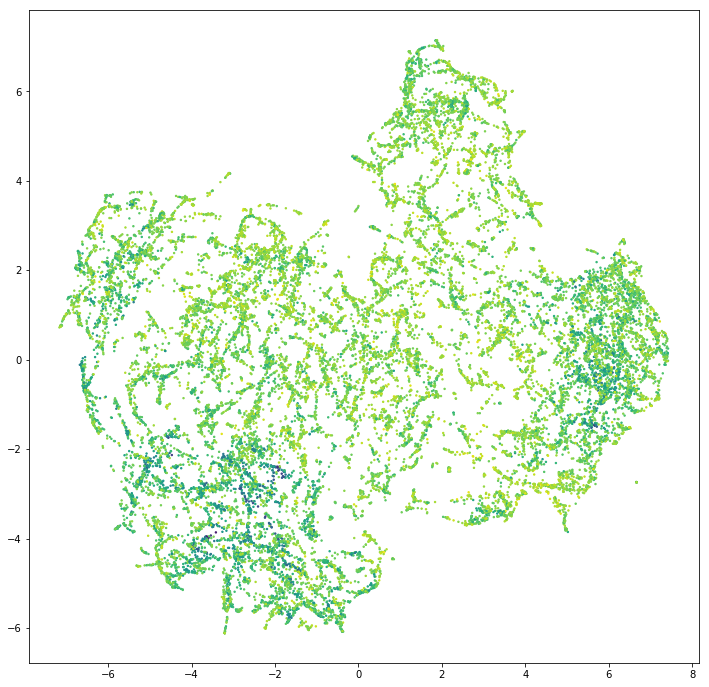

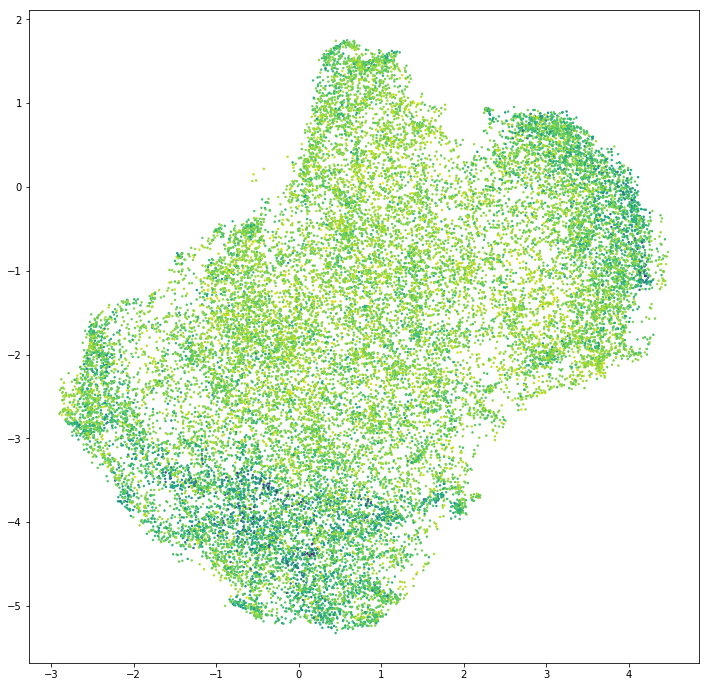

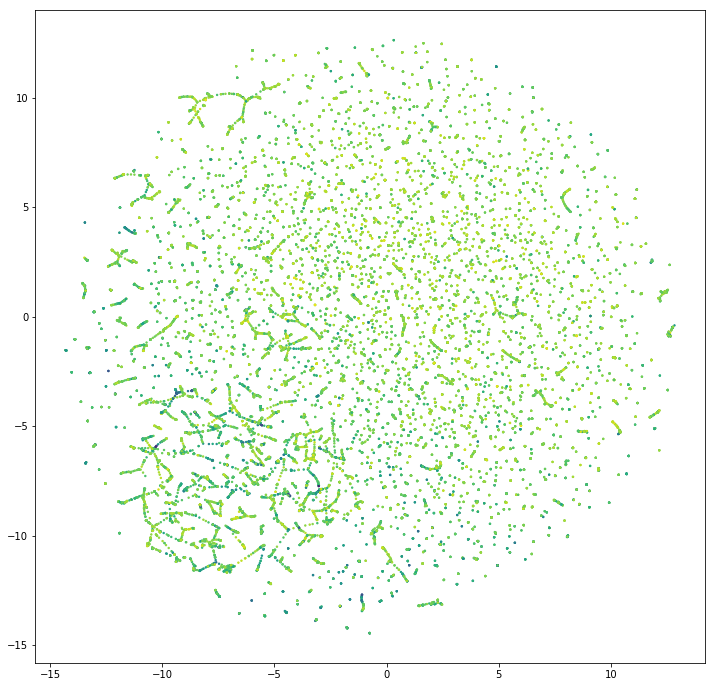

In [9]:
### Client data factory - would run diffetent instances of Processing with different operations
# instance of processing creates options for many outputs
Data = Processor(Glitne.near, Glitne.far, Glitne.twt)
processing_a = Data([Glitne.horizons['top_heimdal'], 12,52], [10, 20])
processing_b = Data([Glitne.horizons['top_heimdal'], 10,10], [10, 20])


### Client model creator/run - run many different instances of the VAE with different parameters
# an instance of a model is one model of dim reduction
UMAP_a = UMAP(processing_a)
UMAP_a1 = UMAP_a.reduce(n_neighbors=10)
UMAP_a2 = UMAP_a.reduce(n_neighbors=100)

UMAP_b = UMAP(processing_b)
UMAP_b1 = UMAP_b.reduce(n_neighbors=2)
# UMAP_b2 = UMAP_b.reduce(n_neighbors=6)
# UMAP_b3 = UMAP_b.reduce(n_neighbors=200)




ModelAgent initialised
adf torch.Size([25351, 2, 64])
Train Epoch: 1 [0/12675 (0%)]	Loss: 10.490456


/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [320/12675 (3%)]	Loss: 9.069143
Train Epoch: 1 [640/12675 (5%)]	Loss: 9.465123
Train Epoch: 1 [960/12675 (8%)]	Loss: 9.958162
Train Epoch: 1 [1280/12675 (10%)]	Loss: 9.143352
Train Epoch: 1 [1600/12675 (13%)]	Loss: 9.186003
Train Epoch: 1 [1920/12675 (15%)]	Loss: 10.165959
Train Epoch: 1 [2240/12675 (18%)]	Loss: 9.437402
Train Epoch: 1 [2560/12675 (20%)]	Loss: 8.603914
Train Epoch: 1 [2880/12675 (23%)]	Loss: 8.702577
Train Epoch: 1 [3200/12675 (25%)]	Loss: 9.476580
Train Epoch: 1 [3520/12675 (28%)]	Loss: 8.718252
Train Epoch: 1 [3840/12675 (30%)]	Loss: 9.322426
Train Epoch: 1 [4160/12675 (33%)]	Loss: 9.513527
Train Epoch: 1 [4480/12675 (35%)]	Loss: 8.308468
Train Epoch: 1 [4800/12675 (38%)]	Loss: 8.732612
Train Epoch: 1 [5120/12675 (40%)]	Loss: 8.402189
Train Epoch: 1 [5440/12675 (43%)]	Loss: 8.782229
Train Epoch: 1 [5760/12675 (45%)]	Loss: 9.330944
Train Epoch: 1 [6080/12675 (48%)]	Loss: 8.524353
Train Epoch: 1 [6400/12675 (50%)]	Loss: 8.795778
Train Epoch: 1 [6720/1267

Train Epoch: 5 [960/12675 (8%)]	Loss: 7.554375
Train Epoch: 5 [1280/12675 (10%)]	Loss: 7.845208
Train Epoch: 5 [1600/12675 (13%)]	Loss: 7.945983
Train Epoch: 5 [1920/12675 (15%)]	Loss: 7.695492
Train Epoch: 5 [2240/12675 (18%)]	Loss: 7.433539
Train Epoch: 5 [2560/12675 (20%)]	Loss: 7.805646
Train Epoch: 5 [2880/12675 (23%)]	Loss: 7.376757
Train Epoch: 5 [3200/12675 (25%)]	Loss: 7.368836
Train Epoch: 5 [3520/12675 (28%)]	Loss: 7.908691
Train Epoch: 5 [3840/12675 (30%)]	Loss: 7.772228
Train Epoch: 5 [4160/12675 (33%)]	Loss: 8.187667
Train Epoch: 5 [4480/12675 (35%)]	Loss: 7.667524
Train Epoch: 5 [4800/12675 (38%)]	Loss: 7.913697
Train Epoch: 5 [5120/12675 (40%)]	Loss: 7.650982
Train Epoch: 5 [5440/12675 (43%)]	Loss: 7.980828
Train Epoch: 5 [5760/12675 (45%)]	Loss: 7.455740
Train Epoch: 5 [6080/12675 (48%)]	Loss: 7.418107
Train Epoch: 5 [6400/12675 (50%)]	Loss: 7.009541
Train Epoch: 5 [6720/12675 (53%)]	Loss: 7.496047
Train Epoch: 5 [7040/12675 (55%)]	Loss: 8.042840
Train Epoch: 5 [7360/1

Train Epoch: 9 [1600/12675 (13%)]	Loss: 7.532824
Train Epoch: 9 [1920/12675 (15%)]	Loss: 7.025772
Train Epoch: 9 [2240/12675 (18%)]	Loss: 7.009831
Train Epoch: 9 [2560/12675 (20%)]	Loss: 7.661436
Train Epoch: 9 [2880/12675 (23%)]	Loss: 7.732334
Train Epoch: 9 [3200/12675 (25%)]	Loss: 7.574130
Train Epoch: 9 [3520/12675 (28%)]	Loss: 7.465896
Train Epoch: 9 [3840/12675 (30%)]	Loss: 7.674891
Train Epoch: 9 [4160/12675 (33%)]	Loss: 7.477133
Train Epoch: 9 [4480/12675 (35%)]	Loss: 7.386003
Train Epoch: 9 [4800/12675 (38%)]	Loss: 7.752064
Train Epoch: 9 [5120/12675 (40%)]	Loss: 8.056767
Train Epoch: 9 [5440/12675 (43%)]	Loss: 7.092463
Train Epoch: 9 [5760/12675 (45%)]	Loss: 7.472502
Train Epoch: 9 [6080/12675 (48%)]	Loss: 7.374221
Train Epoch: 9 [6400/12675 (50%)]	Loss: 7.608651
Train Epoch: 9 [6720/12675 (53%)]	Loss: 7.461227
Train Epoch: 9 [7040/12675 (55%)]	Loss: 7.343846
Train Epoch: 9 [7360/12675 (58%)]	Loss: 6.954336
Train Epoch: 9 [7680/12675 (60%)]	Loss: 7.086210
Train Epoch: 9 [8000

Train Epoch: 13 [1600/12675 (13%)]	Loss: 7.242927
Train Epoch: 13 [1920/12675 (15%)]	Loss: 8.210616
Train Epoch: 13 [2240/12675 (18%)]	Loss: 7.371076
Train Epoch: 13 [2560/12675 (20%)]	Loss: 7.211404
Train Epoch: 13 [2880/12675 (23%)]	Loss: 7.109675
Train Epoch: 13 [3200/12675 (25%)]	Loss: 7.585327
Train Epoch: 13 [3520/12675 (28%)]	Loss: 7.266824
Train Epoch: 13 [3840/12675 (30%)]	Loss: 7.295014
Train Epoch: 13 [4160/12675 (33%)]	Loss: 7.315316
Train Epoch: 13 [4480/12675 (35%)]	Loss: 7.295883
Train Epoch: 13 [4800/12675 (38%)]	Loss: 7.253481
Train Epoch: 13 [5120/12675 (40%)]	Loss: 7.697052
Train Epoch: 13 [5440/12675 (43%)]	Loss: 7.171105
Train Epoch: 13 [5760/12675 (45%)]	Loss: 7.338762
Train Epoch: 13 [6080/12675 (48%)]	Loss: 7.345813
Train Epoch: 13 [6400/12675 (50%)]	Loss: 7.213174
Train Epoch: 13 [6720/12675 (53%)]	Loss: 7.244370
Train Epoch: 13 [7040/12675 (55%)]	Loss: 7.221853
Train Epoch: 13 [7360/12675 (58%)]	Loss: 7.519826
Train Epoch: 13 [7680/12675 (60%)]	Loss: 7.428860


Train Epoch: 17 [1280/12675 (10%)]	Loss: 7.839659
Train Epoch: 17 [1600/12675 (13%)]	Loss: 7.106651
Train Epoch: 17 [1920/12675 (15%)]	Loss: 7.054311
Train Epoch: 17 [2240/12675 (18%)]	Loss: 7.416504
Train Epoch: 17 [2560/12675 (20%)]	Loss: 7.652665
Train Epoch: 17 [2880/12675 (23%)]	Loss: 7.279623
Train Epoch: 17 [3200/12675 (25%)]	Loss: 7.910940
Train Epoch: 17 [3520/12675 (28%)]	Loss: 7.344648
Train Epoch: 17 [3840/12675 (30%)]	Loss: 7.279127
Train Epoch: 17 [4160/12675 (33%)]	Loss: 7.468103
Train Epoch: 17 [4480/12675 (35%)]	Loss: 7.378931
Train Epoch: 17 [4800/12675 (38%)]	Loss: 7.076696
Train Epoch: 17 [5120/12675 (40%)]	Loss: 6.918180
Train Epoch: 17 [5440/12675 (43%)]	Loss: 7.150894
Train Epoch: 17 [5760/12675 (45%)]	Loss: 7.057528
Train Epoch: 17 [6080/12675 (48%)]	Loss: 7.727106
Train Epoch: 17 [6400/12675 (50%)]	Loss: 7.165364
Train Epoch: 17 [6720/12675 (53%)]	Loss: 7.092027
Train Epoch: 17 [7040/12675 (55%)]	Loss: 7.137016
Train Epoch: 17 [7360/12675 (58%)]	Loss: 6.932469


Train Epoch: 21 [960/12675 (8%)]	Loss: 7.673662
Train Epoch: 21 [1280/12675 (10%)]	Loss: 7.306889
Train Epoch: 21 [1600/12675 (13%)]	Loss: 7.575645
Train Epoch: 21 [1920/12675 (15%)]	Loss: 7.642895
Train Epoch: 21 [2240/12675 (18%)]	Loss: 7.445402
Train Epoch: 21 [2560/12675 (20%)]	Loss: 7.392763
Train Epoch: 21 [2880/12675 (23%)]	Loss: 7.348995
Train Epoch: 21 [3200/12675 (25%)]	Loss: 7.671630
Train Epoch: 21 [3520/12675 (28%)]	Loss: 7.293384
Train Epoch: 21 [3840/12675 (30%)]	Loss: 7.692274
Train Epoch: 21 [4160/12675 (33%)]	Loss: 7.312055
Train Epoch: 21 [4480/12675 (35%)]	Loss: 6.886008
Train Epoch: 21 [4800/12675 (38%)]	Loss: 7.433298
Train Epoch: 21 [5120/12675 (40%)]	Loss: 7.012420
Train Epoch: 21 [5440/12675 (43%)]	Loss: 7.633004
Train Epoch: 21 [5760/12675 (45%)]	Loss: 7.228976
Train Epoch: 21 [6080/12675 (48%)]	Loss: 6.996178
Train Epoch: 21 [6400/12675 (50%)]	Loss: 7.340789
Train Epoch: 21 [6720/12675 (53%)]	Loss: 7.469359
Train Epoch: 21 [7040/12675 (55%)]	Loss: 7.413033
Tr

Train Epoch: 25 [640/12675 (5%)]	Loss: 7.310700
Train Epoch: 25 [960/12675 (8%)]	Loss: 7.056397
Train Epoch: 25 [1280/12675 (10%)]	Loss: 7.483995
Train Epoch: 25 [1600/12675 (13%)]	Loss: 7.567501
Train Epoch: 25 [1920/12675 (15%)]	Loss: 7.413823
Train Epoch: 25 [2240/12675 (18%)]	Loss: 6.836999
Train Epoch: 25 [2560/12675 (20%)]	Loss: 6.892438
Train Epoch: 25 [2880/12675 (23%)]	Loss: 7.458770
Train Epoch: 25 [3200/12675 (25%)]	Loss: 7.680179
Train Epoch: 25 [3520/12675 (28%)]	Loss: 7.476032
Train Epoch: 25 [3840/12675 (30%)]	Loss: 7.229795
Train Epoch: 25 [4160/12675 (33%)]	Loss: 7.751881
Train Epoch: 25 [4480/12675 (35%)]	Loss: 6.968673
Train Epoch: 25 [4800/12675 (38%)]	Loss: 7.011344
Train Epoch: 25 [5120/12675 (40%)]	Loss: 7.215482
Train Epoch: 25 [5440/12675 (43%)]	Loss: 7.510500
Train Epoch: 25 [5760/12675 (45%)]	Loss: 7.549519
Train Epoch: 25 [6080/12675 (48%)]	Loss: 7.141331
Train Epoch: 25 [6400/12675 (50%)]	Loss: 7.390796
Train Epoch: 25 [6720/12675 (53%)]	Loss: 7.053187
Trai

Train Epoch: 29 [320/12675 (3%)]	Loss: 7.739185
Train Epoch: 29 [640/12675 (5%)]	Loss: 7.505915
Train Epoch: 29 [960/12675 (8%)]	Loss: 7.513749
Train Epoch: 29 [1280/12675 (10%)]	Loss: 7.060152
Train Epoch: 29 [1600/12675 (13%)]	Loss: 7.586297
Train Epoch: 29 [1920/12675 (15%)]	Loss: 6.840383
Train Epoch: 29 [2240/12675 (18%)]	Loss: 7.747016
Train Epoch: 29 [2560/12675 (20%)]	Loss: 7.091474
Train Epoch: 29 [2880/12675 (23%)]	Loss: 7.486331
Train Epoch: 29 [3200/12675 (25%)]	Loss: 7.728817
Train Epoch: 29 [3520/12675 (28%)]	Loss: 7.302335
Train Epoch: 29 [3840/12675 (30%)]	Loss: 7.407858
Train Epoch: 29 [4160/12675 (33%)]	Loss: 6.963052
Train Epoch: 29 [4480/12675 (35%)]	Loss: 7.057878
Train Epoch: 29 [4800/12675 (38%)]	Loss: 7.509538
Train Epoch: 29 [5120/12675 (40%)]	Loss: 7.365884
Train Epoch: 29 [5440/12675 (43%)]	Loss: 7.445880
Train Epoch: 29 [5760/12675 (45%)]	Loss: 7.139553
Train Epoch: 29 [6080/12675 (48%)]	Loss: 7.471508
Train Epoch: 29 [6400/12675 (50%)]	Loss: 6.948330
Train 

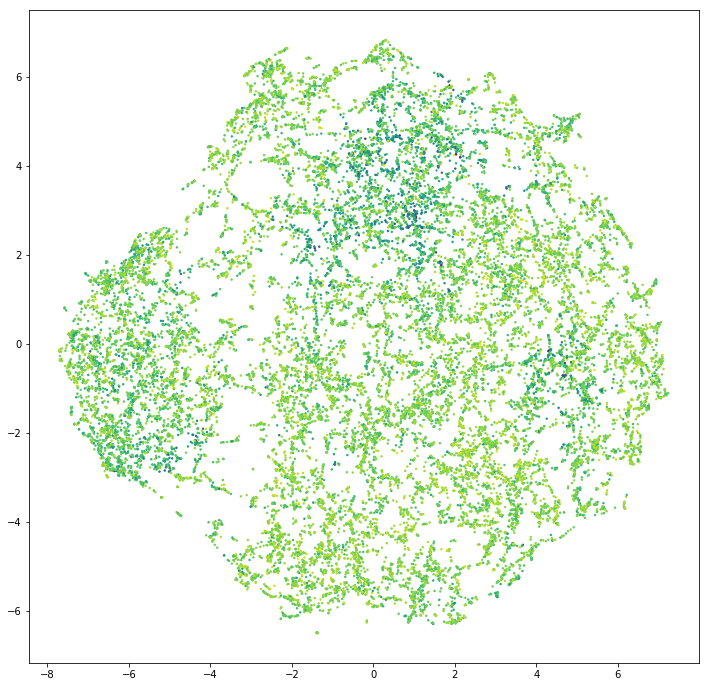

In [10]:
# give data once
VAE_a = VAE_model(processing_a)

# run with different params
VAE_a.create_dataloader()
VAE_a.train_vae()
VAE_a.run_vae()
VAE_a.vae_umap()